The Gurney flap is a small plate attached to or near the trailing edge of an airfoil, perpendicular to the flow on the pressure side.
Being counterintuitive to the idea of a streamlined body, the Gurney flap was invented more or less accidentally by race car driver Dan Gurney.

There are two basic (and somewhat overlapping) explanations for the lift-enhancing effect:

- The flap effectively increases camber [1], decelerating flow on the pressure side and accelerating flow on the suction side.
- The flap decelerates the flow on the pressure side right until the edge and leads to a pressure difference between suction and pressure side which in turn leads to an increased circulation [2].

However, the flow is rather complex and includes unsteady vortex-shedding[3] at the trailing edge.

To model the effects of a Gurney flap with viiflow, a single virtual displacement element is used depending on the position of the Gurney flap. 
The effect of Gurney flap position and height is analyzed and compared to the experimental results.
As far as the author knows, this is the first numerical analysis of Gurney flaps using a panel method.
The possibility of modeling the effect of a Gurney flap using a change in the Kutta condition of a panel method has been proposed in [2], but no function that correlates the Kutta condition (or a step in pressure) to the Gurney flap height is given.

The effect of Gurney flaps on the lift of an airfoil are surprisingly well predicted with viiflow.
This does not hold for the drag, though.
The drag increase for Gurney flaps that are not at the trailing edge can be computed with similar accuracy compared to a fully-turbulent RANS solution, but the coefficients were significantly overpredicted. 
For Gurney flaps right at the trailing edge, the drag cannot be computed using the wake boundary layer at this point, and the additional drag due to the Gurney flap is estimated using the local pressure at the flap.


## Experiments
The most comprehensive experimental analysis to date on an airfoil can be found in [7] where the S903 airfoil has been analyzed.
The coordinates of the airfoil can be found in [8], the paneling has been increased near the trailing edge.
Gurney flap position, height and influence of transition location have been evaluated.
In [4] some of these experimental results are compared with computational results with a fully-turbulent RANS solver. 
A note on these experimental results: the legend in the drag polar plot in [7], Fig. 6, is wrong.
Here, the plots have been changed assuming decreasing drag at higher lift coefficients with decreasing chord position. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"

colors = ['k','k','k','k','k','k','k','k','k']
marks = ['o','^','v','<','>','d','^','^','^']

## Results
In all cases, viiflow accurately predicts the increase in lift and change in maximum lift.
The drag coefficient is less accurately predicted.

Where the Gurney flap is right at the trailing edge, the increase in drag is invisible to viiflow without further modifications.
In viiflow, the drag is calculated using the Squire-Young formula using the wake boundary layer development.
The wake boundary layer development depends on its initialization at the trailing edge, which is done by adding the momentum and displacement thickness of suction and pressure side and a weighted average of the shear-stress.
At this point, the modeling of the flow at the trailing edge is insufficient to describe the development of the wake behind a Gurney flap. 
However, the increase in drag seems to be largely dependent on the pressure difference at the Gurney flap [6].
Adding the pressure afterwards to the drag coefficient markedly improves the drag prediction.
In fact, the resulting polar matches the experiments better than the results of a Gurney flap at .9c or .95c.

If the transition is forced early on, the increase in drag matches the results of the RANS calculations better, though still with a significant drag bucket at low AOA. 
Without forced transition, the results do not get closer to the experimental results but vary significantly over the lift coefficient.
Both computational methods overpredict the increase in drag.

In [5]:
# We go through the experiments using the list below,
# using hgv, the vector of gurney flap heights
# and using pchord, the position of the gurney flap
N = 180
AF = vft.repanel(vft.read_selig("S903RF.dat"),int(N),REFLIMS=[1.0,1.0,0.8,1.0],KAPFAC=.5,REFVAL=3,LEFAC=5,TEFAC = .5)

# Virtual displacement
hgv = np.asarray([0.0,0.005,0.01,0.02,0.02,0.02,0.02,0,0.01])
pchord = [1,1,1,1,.95,.9,.9,.9,-1.0]
forced = np.asarray([0,0,0,0,0,0,1,1,0])

pol = []
AOARANGE = []

AOARANGE.append(np.arange(4.5,-13,-0.5))
AOARANGE.append(np.arange(5,18,0.5))

# Go over experiment setup
for i in range(len(hgv)):
#for i in range(4):
    hg = hgv[i] 
    pc = pchord[i]

    # Gurney flap displacement
    vd = 0*AF[0,:]
    if pc>=1.0:
        index_gf = N-1
        index_gfp = N-2
    elif pc<=-1.0:
        index_gf = 0
        index_gfp = 1
    else:
        for k in range(1,AF.shape[1]):
            if AF[0,-k]<pc:
                index_gf = N-k
                index_gfp = N-k-1
                break
    vd[index_gf] = hg


    # Solver Setup
    RE = 1.0e6
    AOA0 = AOARANGE[0]
    # Not sure why the authors only state "Mach less than 0.2", with the chord length and RE of 1e6 it should be 0.1.
    Mach = 0.1 
    # Ncrit = 8 is a better fit to the end of the drag bucket for the non-Gurney airfoil
    Ncrit = 8 
    
    s = vf.setup(Re=RE,Ma = Mach,Ncrit=Ncrit) 
    s.IterateWakes = False
    s.Itermax = 200
    s.Silent = True
    # Use incompressible boundary layer calculation.
    s.IncompressibleBL = 1
    s.StepsizeLimit = 0.1 # Restricting the stepsize is beneficial here for some AOA
    s.ShearLagType = 1 # Better fit with RFOIL-type shear lag equation

    alv = []
    clv = []
    cdv = []
    cdvg = []
    cdvg2 = []

    for j in range(2): # aoa up and down
        
        init = True
        
        for alpha in AOARANGE[j]:
            s.Alpha = alpha
            s.Ncrit = Ncrit
            
            if init:
                # Set-up and initialize based on inviscid panel solution
                (p,bl,x) = vf.init(AF,s)
                x[p.foils[0].N::p.foils[0].N+p.wakes[0].N-1]+=0.03#2*vd[-1]
                xn = x.copy()
                
                # Trigger transition a bit upstream of the GF
                if hg>0:
                    if pc>0:
                        xtrans = p.foils[0].X[0,index_gf]-0.001
                        vf.set_forced_transition(bl,p,[],[xtrans])
                    else:
                        xtrans = p.foils[0].X[0,index_gf]-0.001
                        vf.set_forced_transition(bl,p,[xtrans],[])

                # For the forced transition comparison use values near leading edge
                if forced[i]:
                    vf.set_forced_transition(bl,p,[.05],[.05])
                init = False

            res = None
            grad = None
            [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[vd])
            # Plot geometry

            nres=np.sqrt(np.dot(res.T,res))

            if flag>0:
                # Add to end or start of polar list
                if j == 1:pos = len(alv)
                else: pos = 0
                
                # Add pressure at gf. cp = 1-ue²/2
                # cp_before: 1-0, cpafter: 1-ue²/2, cd: cp_before-cp_after
                ue_gf = bl[0].bl_fl.nodes[index_gf].ue
                ue_gfp = bl[0].bl_fl.nodes[index_gfp].ue
                cdvg.insert(pos,hg*(0.5*ue_gf**2))
                cdvg2.insert(pos,hg*(0.5*(ue_gfp**2)))

                alv.insert(pos,alpha)
                clv.insert(pos,p.CL)
                cdv.insert(pos,bl[0].CD)
            else:
                init = True

    pol.append({'CL': np.asarray(clv), 'CD': np.asarray(cdv), 'CDg':np.asarray(cdvg),'CDg2':np.asarray(cdvg2), 'hg': hg, 'al': np.asarray(alv)})


 xi=0.970585,delta=0.000000,theta=0.000000,ue=25023431.857629,typ=laminar,
 res=[24.0252,-33.4411,107086]
 dx=[-2.38651e-09,-2.24275e+07,-115273]
 x=[6.78024e-10,2.50234e+07,107087] 
 lam=0.071027 H=1.994720 HS=1.665434 US=0.000000.

 xi=0.970585,delta=0.000000,theta=0.000000,ue=25028561.060968,typ=laminar,
 res=[24.0367,-33.4423,1362.74]
 dx=[-2.39379e-09,-2.25006e+07,-1466.59]
 x=[6.78024e-10,2.50286e+07,1364.24] 
 lam=0.070811 H=1.994720 HS=1.665434 US=0.000000.

 xi=0.970673,delta=0.000000,theta=0.000000,ue=34581895.352869,typ=laminar,
 res=[26.15,-34.909,-298587]
 dx=[-1.71713e-09,-4.38352e+07,-20859.9]
 x=[5.41257e-10,3.45819e+07,19217.5] 
 lam=0.078803 H=2.098953 HS=1.644011 US=0.000000.

 xi=0.970673,delta=0.000000,theta=0.000000,ue=33170092.663276,typ=laminar,
 res=[19.8297,-32.4522,13318.1]
 dx=[2.10151e-10,3.71292e+06,-10560.2]
 x=[5.88418e-10,3.31701e+07,13319.6] 
 lam=0.466663 H=1.930725 HS=1.680119 US=0.000000.

 xi=0.970673,delta=0.000000,theta=0.000000,ue=87049549.13756

 xi=0.971570,delta=0.000000,theta=0.000000,ue=3175057602601.437500,typ=laminar,
 res=[23.9673,-40.2794,-8.22751e+07]
 dx=[5.90188e-13,5.78516e+11,7.3939e+07]
 x=[1.59178e-12,3.17506e+12,3.70713e+07] 
 lam=0.449511 H=1.804816 HS=1.712833 US=0.000000.

 xi=0.971570,delta=0.000000,theta=0.000000,ue=3175057602601.437500,typ=laminar,
 res=[23.9673,-40.2794,-8.22751e+07]
 dx=[5.90188e-13,5.78516e+11,7.3939e+07]
 x=[1.59178e-12,3.17506e+12,3.70713e+07] 
 lam=0.449511 H=1.804816 HS=1.712833 US=0.000000.

 xi=0.971573,delta=0.000000,theta=0.000000,ue=4123199380324.236816,typ=laminar,
 res=[25.1262,-41.4945,-1.04342e+08]
 dx=[-1.45281e-12,-2.04459e+12,-2.85303e+08]
 x=[1.17979e-12,4.1232e+12,4.22598e+07] 
 lam=0.203019 H=2.045457 HS=1.654637 US=0.000000.

 xi=0.971573,delta=0.000000,theta=0.000000,ue=4123199380324.236816,typ=laminar,
 res=[25.1262,-41.4945,-1.04342e+08]
 dx=[-1.45281e-12,-2.04459e+12,-2.85303e+08]
 x=[1.17979e-12,4.1232e+12,4.22598e+07] 
 lam=0.203019 H=2.045457 HS=1.654637 US=0

 xi=0.972123,delta=0.000000,theta=0.000000,ue=2412357374067.659668,typ=laminar,
 res=[32.7061,-59.3602,-7.38596e+07]
 dx=[-5.22022e-12,-5.60618e+12,4.10918e+07]
 x=[1.3027e-12,2.41236e+12,5.69796e+07] 
 lam=0.062387 H=2.323052 HS=1.606958 US=0.000000.

 xi=0.972137,delta=0.000000,theta=0.000000,ue=2743689780627.639160,typ=laminar,
 res=[23.0488,-43.1727,-4.53193e+07]
 dx=[4.54197e-13,3.8698e+11,4.37047e+07]
 x=[1.56511e-12,2.74369e+12,6.89376e+07] 
 lam=0.574315 H=1.910046 HS=1.685133 US=0.000000.

 xi=0.972137,delta=0.000000,theta=0.000000,ue=2743689780627.639160,typ=laminar,
 res=[23.0488,-43.1727,-4.53193e+07]
 dx=[4.54197e-13,3.8698e+11,4.37047e+07]
 x=[1.56511e-12,2.74369e+12,6.89376e+07] 
 lam=0.574315 H=1.910046 HS=1.685133 US=0.000000.

 xi=0.972141,delta=0.000000,theta=0.000000,ue=3569419515570.744141,typ=laminar,
 res=[33.1924,-56.4313,-1.12443e+08]
 dx=[-2.82494e-12,-5.3288e+12,1.60596e+07]
 x=[1.10262e-12,3.56942e+12,4.22801e+07] 
 lam=0.097579 H=2.277419 HS=1.613610 US=0.0

 xi=0.972654,delta=0.000000,theta=0.000000,ue=2726231098485.111816,typ=laminar,
 res=[21.5522,-37.0603,-7.32098e+07]
 dx=[7.38006e-13,6.28058e+11,4.894e+07]
 x=[1.78443e-12,2.72623e+12,3.79918e+07] 
 lam=0.402985 H=1.756440 HS=1.726885 US=0.000000.

 xi=0.972654,delta=0.000000,theta=0.000000,ue=2726231098485.111816,typ=laminar,
 res=[21.5522,-37.0603,-7.32098e+07]
 dx=[7.38006e-13,6.28058e+11,4.894e+07]
 x=[1.78443e-12,2.72623e+12,3.79918e+07] 
 lam=0.402985 H=1.756440 HS=1.726885 US=0.000000.

 xi=0.972658,delta=0.000000,theta=0.000000,ue=3848804942706.123047,typ=laminar,
 res=[22.3517,-37.6726,-9.45619e+07]
 dx=[6.58527e-13,9.36309e+11,6.31004e+07]
 x=[1.50691e-12,3.8488e+12,3.84231e+07] 
 lam=0.381385 H=1.747125 HS=1.729693 US=0.000000.

 xi=0.972658,delta=0.000000,theta=0.000000,ue=3848804942706.123047,typ=laminar,
 res=[22.3517,-37.6726,-9.45619e+07]
 dx=[6.58527e-13,9.36309e+11,6.31004e+07]
 x=[1.50691e-12,3.8488e+12,3.84231e+07] 
 lam=0.381385 H=1.747125 HS=1.729693 US=0.000000.

 xi=0.974656,delta=0.000000,theta=0.000000,ue=359358304.186972,typ=laminar,
 res=[26.2969,-38.7936,164964]
 dx=[8.04241e-11,5.21992e+07,647728]
 x=[1.78005e-10,3.59358e+08,164965] 
 lam=0.368888 H=1.864681 HS=1.696614 US=0.000000.

 xi=0.974960,delta=0.000000,theta=0.000000,ue=569563418.177413,typ=laminar,
 res=[33.2845,-40.3048,-964185]
 dx=[-4.65661e-10,-1.95575e+09,-538944]
 x=[1.16162e-10,5.69563e+08,505334] 
 lam=0.062364 H=2.255760 HS=1.616918 US=0.000000.

 xi=0.974960,delta=0.000000,theta=0.000000,ue=604027848.553989,typ=laminar,
 res=[32.6428,-36.4457,329361]
 dx=[-2.32831e-10,-0,-408473]
 x=[1.23093e-10,6.04028e+08,354486] 
 lam=0.132170 H=2.128756 HS=1.638411 US=0.000000.

 xi=0.974960,delta=0.000000,theta=0.000000,ue=1380532872.808069,typ=laminar,
 res=[24.3788,-36.8396,-1.07667e+06]
 dx=[-2.32831e-10,-0,-1.34376e+06]
 x=[7.42581e-11,1.38053e+09,1.23662e+06] 
 lam=0.079734 H=2.117222 HS=1.640552 US=0.000000.

 xi=0.975006,delta=0.000000,theta=0.000000,ue=5617320366815367237

 xi=0.975177,delta=0.000000,theta=0.000000,ue=3135041577330.190430,typ=laminar,
 res=[21.79,-41.64,-5.54093e+07]
 dx=[2.57439e-10,3.00866e+14,-5.25136e+09]
 x=[1.85058e-12,3.13504e+12,8.31733e+07] 
 lam=0.001198 H=1.597961 HS=1.779528 US=0.000000.

 xi=0.975177,delta=0.000000,theta=0.000000,ue=3135041577330.190430,typ=laminar,
 res=[21.79,-41.64,-5.54093e+07]
 dx=[2.57439e-10,3.00866e+14,-5.25136e+09]
 x=[1.85058e-12,3.13504e+12,8.31733e+07] 
 lam=0.001198 H=1.597961 HS=1.779528 US=0.000000.

 xi=0.975180,delta=0.000000,theta=0.000000,ue=4120204792050.004883,typ=laminar,
 res=[19.4249,-36.4513,-6.16658e+07]
 dx=[4.49881e-13,7.6243e+11,4.20856e+07]
 x=[1.37825e-12,4.1202e+12,7.64441e+07] 
 lam=0.510596 H=1.802296 HS=1.713544 US=0.000000.

 xi=0.975180,delta=0.000000,theta=0.000000,ue=4120204792050.004883,typ=laminar,
 res=[19.4249,-36.4513,-6.16658e+07]
 dx=[4.49881e-13,7.6243e+11,4.20856e+07]
 x=[1.37825e-12,4.1202e+12,7.64441e+07] 
 lam=0.510596 H=1.802296 HS=1.713544 US=0.000000.

 x

 xi=0.975285,delta=0.000000,theta=0.000000,ue=19746330399447540749406568448.000000,typ=turbulent,
 res=[-1210.94,620.107,-0.000313035]
 dx=[1.85695e-14,4.38751e+28,-6.76579e-12]
 x=[1.52431e-12,1.97463e+28,1e-06] 
 lam=0.036241 H=2.068709 HS=1.563308 US=0.295139.

 xi=0.975323,delta=0.000000,theta=0.000000,ue=2606972381664.221680,typ=laminar,
 res=[13.291,-27.744,-2.73285e+07]
 dx=[3.91191e-13,3.48183e+11,2.96966e+07]
 x=[1.69806e-12,2.60697e+12,8.22004e+07] 
 lam=0.723458 H=1.834454 HS=1.704647 US=0.000000.

 xi=0.975323,delta=0.000000,theta=0.000000,ue=2606972381664.221680,typ=laminar,
 res=[13.291,-27.744,-2.73285e+07]
 dx=[3.91191e-13,3.48183e+11,2.96966e+07]
 x=[1.69806e-12,2.60697e+12,8.22004e+07] 
 lam=0.723458 H=1.834454 HS=1.704647 US=0.000000.

 xi=0.975327,delta=0.000000,theta=0.000000,ue=3825584218979.809570,typ=laminar,
 res=[15.8051,-29.9346,-6.57265e+07]
 dx=[4.8123e-13,7.0232e+11,5.33854e+07]
 x=[1.49647e-12,3.82558e+12,6.79835e+07] 
 lam=0.518278 H=1.748530 HS=1.729267

 xi=0.975411,delta=0.000000,theta=0.000000,ue=2637424131586.733887,typ=laminar,
 res=[18.8496,-42.3968,-2.87343e+07]
 dx=[-4.03238e-12,-5.07222e+12,4.19569e+07]
 x=[1.21433e-12,2.63742e+12,1.11585e+08] 
 lam=0.075286 H=2.354667 HS=1.602591 US=0.000000.

 xi=0.975411,delta=0.000000,theta=0.000000,ue=1717846499447.669434,typ=laminar,
 res=[12.129,-26.7136,-2.15369e+07]
 dx=[1.34791e-12,6.33471e+11,-2.55957e+07]
 x=[2.4263e-12,1.71785e+12,7.33711e+07] 
 lam=0.300009 H=1.649871 HS=1.761096 US=0.000000.

 xi=0.975411,delta=0.000000,theta=0.000000,ue=1717846499447.669434,typ=laminar,
 res=[12.129,-26.7136,-2.15369e+07]
 dx=[1.34791e-12,6.33471e+11,-2.55957e+07]
 x=[2.4263e-12,1.71785e+12,7.33711e+07] 
 lam=0.300009 H=1.649871 HS=1.761096 US=0.000000.

 xi=0.975415,delta=0.000000,theta=0.000000,ue=2143077579938.985840,typ=laminar,
 res=[9.29964,-21.1063,-6.45126e+06]
 dx=[2.77101e-13,2.14289e+11,924039]
 x=[1.7032e-12,2.14308e+12,9.64213e+07] 
 lam=1.000000 H=1.974275 HS=1.669993 US=0.000000.

 xi=1.584749,delta=0.000452,theta=0.000346,ue=0.259337,typ=wake,
 res=[-0.00175646,-0.085641,2.36691e-05]
 dx=[-2.08185e-05,0.00420264,0.00415161]
 x=[0.000346234,0.259337,0.021772] 
 lam=0.874037 H=1.305889 HS=1.841536 US=0.660914.

 xi=1.584779,delta=0.000455,theta=0.000348,ue=0.258425,typ=wake,
 res=[-0.00173519,-0.0875879,2.32931e-05]
 dx=[-2.03513e-05,0.00408087,0.00404771]
 x=[0.00034771,0.258425,0.021975] 
 lam=0.904831 H=1.307424 HS=1.840897 US=0.659687.

 xi=1.584799,delta=0.000458,theta=0.000350,ue=0.256777,typ=wake,
 res=[-0.00172529,-0.0896803,2.29687e-05]
 dx=[-2.00503e-05,0.00397539,0.00396588]
 x=[0.000349658,0.256777,0.0222099] 
 lam=0.933376 H=1.309225 HS=1.840149 US=0.658253.

 xi=1.584809,delta=0.000459,theta=0.000351,ue=0.256010,typ=wake,
 res=[-0.00172154,-0.0906635,2.28159e-05]
 dx=[-1.99291e-05,0.00393046,0.00393176]
 x=[0.000350561,0.25601,0.0223265] 
 lam=0.946416 H=1.310102 HS=1.839785 US=0.657556.

 xi=1.584822,delta=0.000461,theta=0.000352,ue=0.255060,typ=wa

 xi=1.028901,delta=0.018223,theta=0.001240,ue=0.850702,typ=wake,
 res=[0.226447,-0.00622822,1.10554e-05]
 dx=[0.000205538,0.000159641,-0.0003272]
 x=[0.00123955,0.850702,0.0500952] 
 lam=1.000000 H=9.539871 HS=1.703690 US=-0.066892.

 xi=1.028901,delta=0.018223,theta=0.001220,ue=0.850685,typ=wake,
 res=[0.185085,-0.00402907,7.01232e-06]
 dx=[0.000165296,0.000128247,-0.000257752]
 x=[0.00121998,0.850685,0.0501454] 
 lam=1.000000 H=9.692849 HS=1.708850 US=-0.068798.

 xi=1.028901,delta=0.018223,theta=0.001220,ue=0.850686,typ=wake,
 res=[0.185588,-0.00405259,7.05345e-06]
 dx=[0.000165777,0.000128622,-0.0002585]
 x=[0.00122022,0.850686,0.0501449] 
 lam=1.000000 H=9.690953 HS=1.708786 US=-0.068775.

 xi=1.028901,delta=0.018223,theta=0.001232,ue=0.850696,typ=wake,
 res=[0.21261,-0.00648475,1.16506e-05]
 dx=[0.000218689,0.000169913,-0.000350608]
 x=[0.00123248,0.850696,0.0500992] 
 lam=0.939292 H=9.594597 HS=1.705535 US=-0.067579.

 xi=1.028901,delta=0.018223,theta=0.001220,ue=0.850686,typ=wa

 xi=1.028901,delta=0.018223,theta=0.001224,ue=0.850689,typ=wake,
 res=[0.194195,-0.00446711,7.80451e-06]
 dx=[0.000174028,0.000135055,-0.000272555]
 x=[0.0012243,0.850689,0.0501349] 
 lam=1.000000 H=9.658684 HS=1.707697 US=-0.068376.

 xi=1.028901,delta=0.018223,theta=0.001235,ue=0.850699,typ=wake,
 res=[0.218254,-0.00641005,1.1471e-05]
 dx=[0.000214188,0.000166397,-0.000342555]
 x=[0.00123534,0.850699,0.0500972] 
 lam=0.961261 H=9.572341 HS=1.704784 US=-0.067300.

 xi=1.028901,delta=0.018223,theta=0.001225,ue=0.850690,typ=wake,
 res=[0.195479,-0.00453056,7.91919e-06]
 dx=[0.000175258,0.000136018,-0.000274623]
 x=[0.00122491,0.85069,0.0501334] 
 lam=1.000000 H=9.653889 HS=1.707535 US=-0.068317.

 xi=1.028901,delta=0.018223,theta=0.001231,ue=0.850695,typ=wake,
 res=[0.208301,-0.00519539,9.13509e-06]
 dx=[0.000187675,0.000145709,-0.00029594]
 x=[0.00123097,0.850695,0.050118] 
 lam=1.000000 H=9.606307 HS=1.705929 US=-0.067725.

 xi=1.028901,delta=0.018223,theta=0.001235,ue=0.850698,typ=wa

 xi=1.028901,delta=0.018223,theta=0.001238,ue=0.850701,typ=wake,
 res=[0.223823,-0.00607224,1.07632e-05]
 dx=[0.000202936,0.00015761,-0.000322613]
 x=[0.00123831,0.850701,0.0500986] 
 lam=1.000000 H=9.549416 HS=1.704012 US=-0.067012.

 xi=1.028901,delta=0.018223,theta=0.001221,ue=0.850686,typ=wake,
 res=[0.186539,-0.00409731,7.13531e-06]
 dx=[0.000166686,0.00012933,-0.000260099]
 x=[0.00122067,0.850686,0.0501438] 
 lam=1.000000 H=9.687376 HS=1.708666 US=-0.068730.

 xi=1.028901,delta=0.018223,theta=0.001230,ue=0.850693,typ=wake,
 res=[0.205397,-0.00504025,8.85005e-06]
 dx=[0.00018485,0.000143503,-0.000291064]
 x=[0.0012296,0.850693,0.0501215] 
 lam=1.000000 H=9.617039 HS=1.706291 US=-0.067859.

 xi=1.028901,delta=0.018223,theta=0.001231,ue=0.850694,typ=wake,
 res=[0.20792,-0.00517491,9.09754e-06]
 dx=[0.000187305,0.00014542,-0.000295305]
 x=[0.00123079,0.850694,0.0501185] 
 lam=1.000000 H=9.607712 HS=1.705977 US=-0.067743.

 xi=1.028901,delta=0.018223,theta=0.001223,ue=0.850688,typ=wak

 xi=1.028901,delta=0.018223,theta=0.001223,ue=0.850688,typ=wake,
 res=[0.190632,-0.00429256,7.4867e-06]
 dx=[0.000170601,0.000132385,-0.000266662]
 x=[0.00122261,0.850688,0.050139] 
 lam=1.000000 H=9.672013 HS=1.708147 US=-0.068541.

 xi=1.028269,delta=0.022795,theta=0.001135,ue=0.701922,typ=wake,
 res=[-0.214483,-0.00328895,6.46648e-06]
 dx=[-0.000228471,-0.000109949,0.000189707]
 x=[0.00113471,0.701922,0.0699844] 
 lam=1.000000 H=14.450207 HS=1.878843 US=-0.114085.

 xi=1.028330,delta=0.022471,theta=0.001127,ue=0.701428,typ=wake,
 res=[-0.208652,-0.0031949,6.29241e-06]
 dx=[-0.000218511,-0.000107235,0.000196533]
 x=[0.00112682,0.701428,0.0691981] 
 lam=1.000000 H=14.263335 HS=1.871488 US=-0.112616.

 xi=1.028423,delta=0.022175,theta=0.001108,ue=0.701761,typ=wake,
 res=[-0.223489,-0.00370046,7.20034e-06]
 dx=[-0.000229599,-0.000114416,0.000212931]
 x=[0.00110801,0.701761,0.0680177] 
 lam=1.000000 H=14.239092 HS=1.870030 US=-0.112394.

 xi=1.028533,delta=0.021830,theta=0.001321,ue=0.70

 xi=1.028951,delta=0.018825,theta=0.001160,ue=0.821152,typ=wake,
 res=[0.167135,-0.00457059,1.15097e-05]
 dx=[0.00021929,0.000158791,-0.00038237]
 x=[0.00116031,0.821152,0.0541431] 
 lam=0.881867 H=10.710014 HS=1.743859 US=-0.080501.

 xi=1.028951,delta=0.018825,theta=0.001163,ue=0.821153,typ=wake,
 res=[0.171763,-0.00306643,7.44067e-06]
 dx=[0.000167192,0.000121075,-0.000283521]
 x=[0.00116341,0.821153,0.0541704] 
 lam=1.000000 H=10.681443 HS=1.742878 US=-0.080193.

 xi=1.028951,delta=0.018825,theta=0.001176,ue=0.821162,typ=wake,
 res=[0.197109,-0.00420594,1.04257e-05]
 dx=[0.000196956,0.00014263,-0.000339214]
 x=[0.00117563,0.821162,0.0541318] 
 lam=0.994837 H=10.570376 HS=1.739069 US=-0.078987.

 xi=1.028951,delta=0.018825,theta=0.001160,ue=0.821151,typ=wake,
 res=[0.165677,-0.00459126,1.15654e-05]
 dx=[0.000220358,0.000159564,-0.000384366]
 x=[0.00115956,0.821151,0.0541436] 
 lam=0.877029 H=10.716880 HS=1.744095 US=-0.080574.

 xi=1.028951,delta=0.018825,theta=0.001162,ue=0.821153,

 xi=1.028951,delta=0.018825,theta=0.001175,ue=0.821162,typ=wake,
 res=[0.196557,-0.00411277,1.01693e-05]
 dx=[0.000194095,0.000140559,-0.000333773]
 x=[0.0011754,0.821162,0.054134] 
 lam=1.000000 H=10.572460 HS=1.739140 US=-0.079010.

 xi=1.028951,delta=0.018825,theta=0.001158,ue=0.821150,typ=wake,
 res=[0.163467,-0.00462322,1.16527e-05]
 dx=[0.000221975,0.000160734,-0.000387646]
 x=[0.00115843,0.82115,0.0541444] 
 lam=0.869792 H=10.727310 HS=1.744453 US=-0.080686.

 xi=1.028951,delta=0.018825,theta=0.001166,ue=0.821156,typ=wake,
 res=[0.178435,-0.0044193,1.1083e-05]
 dx=[0.00021095,0.000152758,-0.000366111]
 x=[0.00116608,0.821156,0.0541389] 
 lam=0.921292 H=10.657007 HS=1.742040 US=-0.079929.

 xi=1.028951,delta=0.018825,theta=0.001155,ue=0.821148,typ=wake,
 res=[0.156192,-0.00473268,1.19429e-05]
 dx=[0.000227273,0.000164565,-0.000398103]
 x=[0.00115473,0.821148,0.054147] 
 lam=0.846797 H=10.761760 HS=1.745636 US=-0.081055.

 xi=1.028951,delta=0.018825,theta=0.001168,ue=0.821157,typ=

 xi=1.028951,delta=0.018825,theta=0.001160,ue=0.821151,typ=wake,
 res=[0.165574,-0.00459274,1.15695e-05]
 dx=[0.000220434,0.000159619,-0.000384515]
 x=[0.00115951,0.821151,0.0541436] 
 lam=0.876687 H=10.717368 HS=1.744112 US=-0.080580.

 xi=1.028951,delta=0.018825,theta=0.001153,ue=0.821146,typ=wake,
 res=[0.151959,-0.00479945,1.21157e-05]
 dx=[0.000230338,0.00016678,-0.000404187]
 x=[0.00115257,0.821146,0.0541485] 
 lam=0.833971 H=10.781892 HS=1.746328 US=-0.081269.

 xi=1.028951,delta=0.018825,theta=0.001174,ue=0.821161,typ=wake,
 res=[0.193672,-0.00398195,9.82183e-06]
 dx=[0.000190913,0.000138256,-0.000327745]
 x=[0.00117401,0.821161,0.0541384] 
 lam=1.000000 H=10.585020 HS=1.739571 US=-0.079147.

 xi=1.028951,delta=0.018825,theta=0.001167,ue=0.821156,typ=wake,
 res=[0.178942,-0.0033515,8.17282e-06]
 dx=[0.000174883,0.000126646,-0.000297725]
 x=[0.00116688,0.821156,0.0541602] 
 lam=1.000000 H=10.649644 HS=1.741787 US=-0.079850.

 xi=1.028951,delta=0.018825,theta=0.001159,ue=0.821151

 xi=1.028951,delta=0.018825,theta=0.001158,ue=0.821150,typ=wake,
 res=[0.161843,-0.00465221,1.17379e-05]
 dx=[0.000223134,0.000161549,-0.000393344]
 x=[0.0011576,0.82115,0.0541448] 
 lam=0.864655 H=10.735012 HS=1.744718 US=-0.080769.

 xi=1.028951,delta=0.018825,theta=0.001167,ue=0.821157,typ=wake,
 res=[0.180924,-0.00438821,1.09919e-05]
 dx=[0.0002091,0.00015142,-0.000362528]
 x=[0.00116735,0.821157,0.054138] 
 lam=0.930456 H=10.645393 HS=1.741641 US=-0.079804.

 xi=1.028951,delta=0.018825,theta=0.001163,ue=0.821153,typ=wake,
 res=[0.171717,-0.00306467,7.43618e-06]
 dx=[0.000167144,0.00012104,-0.000283432]
 x=[0.00116339,0.821153,0.0541705] 
 lam=1.000000 H=10.681645 HS=1.742885 US=-0.080195.

 xi=1.028951,delta=0.018825,theta=0.001157,ue=0.821149,typ=wake,
 res=[0.160223,-0.0046712,1.1781e-05]
 dx=[0.000224342,0.000162446,-0.000392308]
 x=[0.00115678,0.821149,0.0541456] 
 lam=0.859386 H=10.742648 HS=1.744980 US=-0.080850.

 xi=1.028951,delta=0.018825,theta=0.001169,ue=0.821157,typ=wa

 xi=1.028951,delta=0.018825,theta=0.001157,ue=0.821149,typ=wake,
 res=[0.160041,-0.00467393,1.17883e-05]
 dx=[0.000224475,0.000162542,-0.000392571]
 x=[0.00115669,0.821149,0.0541456] 
 lam=0.858809 H=10.743511 HS=1.745009 US=-0.080860.

 xi=1.028951,delta=0.018825,theta=0.001160,ue=0.821152,typ=wake,
 res=[0.167223,-0.00457455,1.15383e-05]
 dx=[0.000219192,0.000158695,-0.00038614]
 x=[0.00116035,0.821152,0.0541428] 
 lam=0.882293 H=10.709625 HS=1.743846 US=-0.080496.

 xi=1.028951,delta=0.018825,theta=0.001157,ue=0.821149,typ=wake,
 res=[0.160041,-0.00467393,1.17883e-05]
 dx=[0.000224475,0.000162542,-0.000392571]
 x=[0.00115669,0.821149,0.0541456] 
 lam=0.858809 H=10.743511 HS=1.745009 US=-0.080860.

 xi=1.028951,delta=0.018825,theta=0.001166,ue=0.821156,typ=wake,
 res=[0.178435,-0.0044193,1.1083e-05]
 dx=[0.00021095,0.000152758,-0.000366111]
 x=[0.00116608,0.821156,0.0541389] 
 lam=0.921292 H=10.657007 HS=1.742040 US=-0.079929.

 xi=1.028951,delta=0.018825,theta=0.001169,ue=0.821157,t

 xi=1.028951,delta=0.018825,theta=0.001156,ue=0.821149,typ=wake,
 res=[0.158566,-0.00470117,1.18629e-05]
 dx=[0.000225524,0.00016328,-0.000397714]
 x=[0.00115593,0.821149,0.0541461] 
 lam=0.854258 H=10.750521 HS=1.745250 US=-0.080935.

 xi=1.028951,delta=0.018825,theta=0.001152,ue=0.821146,typ=wake,
 res=[0.151785,-0.00480646,1.21296e-05]
 dx=[0.000230445,0.000166842,-0.000406713]
 x=[0.00115248,0.821146,0.0541485] 
 lam=0.833519 H=10.782737 HS=1.746357 US=-0.081278.

 xi=1.028951,delta=0.018825,theta=0.001149,ue=0.821144,typ=wake,
 res=[0.144798,-0.00491749,1.24146e-05]
 dx=[0.00023549,0.000170504,-0.000414474]
 x=[0.00114893,0.821144,0.054151] 
 lam=0.813145 H=10.816085 HS=1.747504 US=-0.081633.

 xi=1.028951,delta=0.018825,theta=0.001164,ue=0.821154,typ=wake,
 res=[0.173809,-0.00314622,7.64477e-06]
 dx=[0.000169376,0.000122657,-0.000287543]
 x=[0.0011644,0.821154,0.0541675] 
 lam=1.000000 H=10.672360 HS=1.742566 US=-0.080095.

 xi=1.028951,delta=0.018825,theta=0.001166,ue=0.821155,t

 xi=1.029906,delta=0.021107,theta=0.001454,ue=0.837273,typ=wake,
 res=[0.190845,-0.00404691,7.94596e-06]
 dx=[0.000204747,0.000127389,-0.000239325]
 x=[0.00145447,0.837273,0.0498175] 
 lam=1.000000 H=10.112768 HS=1.727743 US=-0.074017.

 xi=1.030011,delta=0.020938,theta=0.001408,ue=0.842142,typ=wake,
 res=[0.131591,-0.00752916,1.54664e-05]
 dx=[0.000330823,0.000209628,-0.000416368]
 x=[0.00140799,0.842142,0.0493822] 
 lam=0.709336 H=10.326563 HS=1.735002 US=-0.076468.

 xi=1.030061,delta=0.020903,theta=0.001397,ue=0.844149,typ=wake,
 res=[0.116429,-0.00807291,1.62844e-05]
 dx=[0.000343152,0.000218148,-0.000434334]
 x=[0.00139685,0.844149,0.049195] 
 lam=0.678443 H=10.383839 HS=1.736983 US=-0.077114.

 xi=1.030072,delta=0.020950,theta=0.001425,ue=0.844405,typ=wake,
 res=[0.159189,-0.00693722,1.42889e-05]
 dx=[0.000306331,0.000194314,-0.000388048]
 x=[0.00142483,0.844405,0.0491485] 
 lam=0.775212 H=10.212654 HS=1.731141 US=-0.075171.

 xi=1.030072,delta=0.020968,theta=0.001407,ue=0.84417

 xi=1.030072,delta=0.020968,theta=0.001401,ue=0.844174,typ=wake,
 res=[0.117053,-0.00801444,1.62805e-05]
 dx=[0.000342991,0.000217132,-0.000431834]
 x=[0.00140068,0.844174,0.0491637] 
 lam=0.680621 H=10.401507 HS=1.737694 US=-0.077317.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001413,ue=0.844181,

 xi=1.030072,delta=0.020968,theta=0.001401,ue=0.844174,typ=wake,
 res=[0.117053,-0.00801444,1.62805e-05]
 dx=[0.000342991,0.000217132,-0.000431834]
 x=[0.00140068,0.844174,0.0491637] 
 lam=0.680621 H=10.401507 HS=1.737694 US=-0.077317.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001421,ue=0.844186,typ=wake,
 res=[0.15132,-0.00708538,1.46153e-05]
 dx=[0.000313447,0.000198583,-0.000397447]
 x=[0.00142114,0.844186,0.0491542] 
 lam=0.755648 H=10.251803 HS=1.732515 US=-0.075621.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,

 xi=1.030072,delta=0.020968,theta=0.001413,ue=0.844181,typ=wake,
 res=[0.13719,-0.0073944,1.52339e-05]
 dx=[0.000325913,0.000206531,-0.000414766]
 x=[0.00141272,0.844181,0.0491584] 
 lam=0.722443 H=10.312854 HS=1.734626 US=-0.076317.

 xi=1.030072,delta=0.020968,theta=0.001427,ue=0.844189,typ=wake,
 res=[0.161224,-0.00688353,1.4206e-05]
 dx=[0.000304604,0.000192946,-0.000385237]
 x=[0.00142704,0.844189,0.0491511] 
 lam=0.780818 H=10.209369 HS=1.731049 US=-0.075135.

 xi=1.030072,delta=0.020968,theta=0.001402,ue=0.844175,typ=wake,
 res=[0.120149,-0.00801034,1.61742e-05]
 dx=[0.000340108,0.000215128,-0.000423913]
 x=[0.00140248,0.844175,0.0491627] 
 lam=0.687271 H=10.388202 HS=1.737234 US=-0.077168.

 xi=1.030072,delta=0.020968,theta=0.001407,ue=0.844178,typ=wake,
 res=[0.128309,-0.00799022,1.58704e-05]
 dx=[0.00033244,0.000209799,-0.000402856]
 x=[0.00140722,0.844178,0.0491599] 
 lam=0.705498 H=10.353207 HS=1.736022 US=-0.076774.

 xi=1.030072,delta=0.020968,theta=0.001407,ue=0.844177,t

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001407,ue=0.844177,typ=wake,
 res=[0.127166,-0.00799709,1.59222e-05]
 dx=[0.00033351,0.000210536,-0.000405236]
 x=[0.00140655,0.844177,0.0491602] 
 lam=0.702902 H=10.358117 HS=1.736192 US=-0.076829.

 xi=1.030072,delta=0.020968,theta=0.001401,ue=0.844174,typ=wake,
 res=[0.116959,-0.00787906,1.61891e-05]
 dx=[0.000343456,0.000217718,-0.000439336]
 x=[0.00140071,0.844174,0.0491643] 
 lam=0.679712 H=10.401327 HS=1.737688 US=-0.077315.

 xi=1.030072,delta=0.020968,theta=0.001407,ue=0.844177,typ=wake,
 res=[0.127166,-0.00799709,1.59222e-05]
 dx=[0.00033351,0.000210536,-0.000405236]
 x=[0.00140655,0.844177,0.0491602] 
 lam=0.702902 H=10.358117 HS=1.736192 US=-0.076829.

 xi=1.030072,delta=0.020968,theta=0.001427,ue=0.844189,

 xi=1.030072,delta=0.020968,theta=0.001401,ue=0.844174,typ=wake,
 res=[0.116959,-0.00787906,1.61891e-05]
 dx=[0.000343456,0.000217718,-0.000439336]
 x=[0.00140071,0.844174,0.0491643] 
 lam=0.679712 H=10.401327 HS=1.737688 US=-0.077315.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125852,-0.00765995,1.57592e-05]
 dx=[0.000335788,0.000212828,-0.000428567]
 x=[0.00140598,0.844177,0.0491617] 
 lam=0.697853 H=10.362280 HS=1.736336 US=-0.076876.

 xi=1.030072,delta=0.020968,theta=0.001401,ue=0.844174,typ=wake,
 res=[0.117053,-0.00801444,1.62805e-05]
 dx=[0.000342991,0.000217132,-0.000431834]
 x=[0.00140068,0.844174,0.0491637] 
 lam=0.680621 H=10.401507 HS=1.737694 US=-0.077317.

 xi=1.030072,delta=0.020968,theta=0.001406,ue=0.844177,typ=wake,
 res=[0.125282,-0.00767373,1.57863e-05]
 dx=[0.000336282,0.000213143,-0.00042926]
 x=[0.00140565,0.844177,0.0491619] 
 lam=0.696659 H=10.364778 HS=1.736423 US=-0.076904.

 xi=1.030072,delta=0.020968,theta=0.001403,ue=0.84417

 xi=0.978953,delta=0.036487,theta=0.035925,ue=0.542654,typ=turbulent,
 res=[-0.000243824,0.0134014,1.23595e-05]
 dx=[0.0308639,-0.225168,0.034525]
 x=[0.0359251,0.542654,0.0842659] 
 lam=0.010769 H=1.015633 HS=1.987221 US=0.975184.

 xi=0.980030,delta=0.029609,theta=0.018477,ue=0.776942,typ=turbulent,
 res=[-0.00963478,0.00327166,-5.03395e-05]
 dx=[0.00182484,-0.0222455,0.00282945]
 x=[0.0184771,0.776942,0.0625322] 
 lam=1.000000 H=1.602457 HS=1.676433 US=0.458536.

 xi=0.978923,delta=0.031414,theta=0.016218,ue=0.781309,typ=turbulent,
 res=[-0.00167275,0.000402412,2.47533e-05]
 dx=[0.000707423,-0.0140691,0.00106248]
 x=[0.0162177,0.781309,0.059088] 
 lam=1.000000 H=1.937021 HS=1.589591 US=0.331570.

 xi=0.980122,delta=0.029523,theta=0.015957,ue=0.816244,typ=turbulent,
 res=[-0.0552435,0.0113775,0.000613833]
 dx=[-0.0152966,0.259933,-0.022664]
 x=[0.0159569,0.816244,0.0592125] 
 lam=0.260792 H=1.850197 HS=1.608087 US=0.358897.

 xi=0.978907,delta=0.031468,theta=0.015998,ue=0.784349,typ=

 xi=0.011772,delta=0.000048,theta=0.000030,ue=0.582335,typ=laminar,
 res=[0.696148,-1.30098,1.99893e-06]
 dx=[4.45784e-05,0.0982232,-2.25529e-06]
 x=[3.04036e-05,0.582335,9.8348e-05] 
 lam=0.113671 H=1.581971 HS=1.785456 US=0.000000.

 xi=0.013278,delta=0.000044,theta=0.000028,ue=0.738862,typ=laminar,
 res=[0.555445,-1.08446,2.43564e-06]
 dx=[5.74789e-05,0.16432,-2.65159e-06]
 x=[2.80869e-05,0.738862,0.000128261] 
 lam=0.081441 H=1.556151 HS=1.795289 US=0.000000.

 xi=0.015068,delta=0.000038,theta=0.000018,ue=0.870387,typ=laminar,
 res=[0.628399,-1.12509,6.9307e-06]
 dx=[-1.64128e-05,-0.062242,1.31621e-05]
 x=[1.83554e-05,0.870387,0.000132756] 
 lam=0.279590 H=2.065042 HS=1.650659 US=0.000000.

 xi=0.014359,delta=0.000037,theta=0.000022,ue=0.886761,typ=laminar,
 res=[0.530572,-0.970964,3.88843e-06]
 dx=[7.79137e-06,0.0208494,-7.4285e-06]
 x=[2.22779e-05,0.886761,0.000129714] 
 lam=0.476552 H=1.679023 HS=1.751269 US=0.000000.

 xi=0.013018,delta=0.000039,theta=0.000022,ue=0.820715,typ=l

Text(0.5, 0, 'CD')

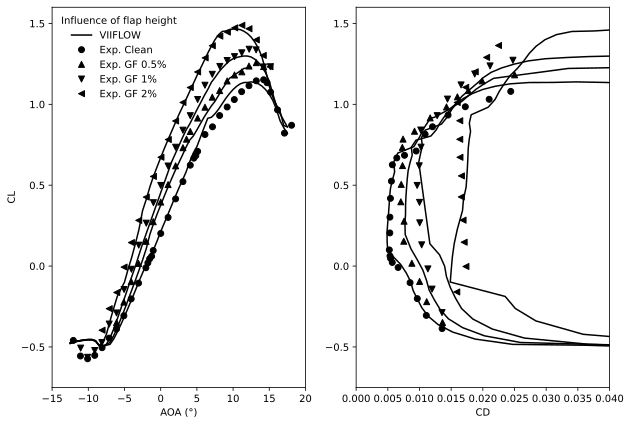

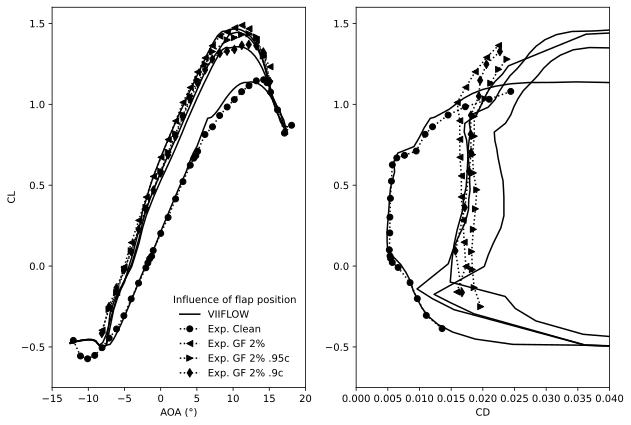

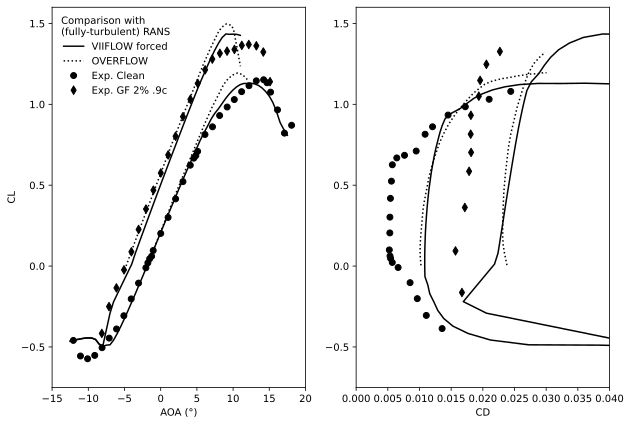

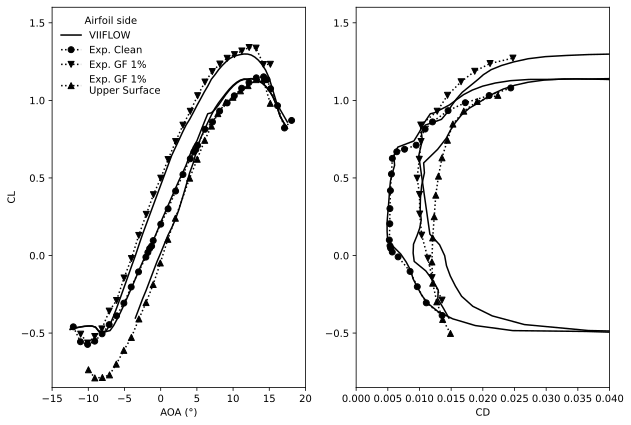

In [6]:
matplotlib.rcParams['figure.figsize'] = [10, 7] # Make plots bigger than default
fig,ax = plt.subplots(1,2)
cmap = plt.get_cmap("tab10")

# Part one, influence of height
namesVF = ['VIIFLOW',None,None,None,\
          None,None,\
          'VIIFLOW forced',None,\
          None]

linestyle_vf = ['-','-','-','-','-','-','-','-','-']

for k in range(4):
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg']),pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg2']),pol[k]['CL'],color='m')


namesEXP = ['Exp. Clean','Exp. GF 0.5%','Exp. GF 1%','Exp. GF 2%','Exp. GF 2% .95c',\
            'Exp. GF 2% .9c','Exp. GF 1%\nUpper Surface']
for k in range(4):
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],'o',color = colors[k],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],'o',color = colors[k],marker=marks[k])

ax[0].legend(frameon=False,title='Influence of flap height')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part two, influence of chord position
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,3,4,5]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg2'],pol[k]['CL'],color='m')
    kcol+=1

kcol = 0
for k in [0,3,4,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],marker=marks[k])
    kcol+=1

ax[0].legend(frameon=False,title = 'Influence of flap position')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part three, comparison with fully-turbulent RANS
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [6,7]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[kcol],label = namesVF[k],linestyle=linestyle_vf[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[kcol],linestyle=linestyle_vf[k])
    kcol+=1
    
# Add CFD results from thesis
names = ['Clean Exp.','OVERFLOW','GF Exp',None]
linestyle = ['o',':','o',':']
for k in [1,3]:
    Data = np.genfromtxt('GurneyS903Lift.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])
    Data = np.genfromtxt('GurneyS903Polar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])    

kcol = 0
for k in [0,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],'o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],'o',color = colors[kcol],marker=marks[k])
    kcol+=1



ax[0].legend(frameon=False,title = 'Comparison with \n(fully-turbulent) RANS')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part four, influence of upper/lower
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,2,8]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[k])
    kcol+=1

kcol = 0
for k in [0,2,6]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],marker=marks[k])
    kcol+=1

ax[0].legend(frameon=False,title = 'Airfoil side')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.85,1.6)
ax[0].set_ylim(-.85,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


## Pressure Distribution
In [7] the pressure coefficients over the airfoil surface is given for a lift coefficient of 0.7.
The effect of the Gurney flap on the pressure is well predicted.
For the 1c Gurney flap, the step in pressure at the trailing edge smaller in the simulations, but the global pressure distribution matches well.
For the .9c configuration the step matches quite well, but the decrease in speed before the flap is underpredicted.

The transition seems to occur rather sooner on the suction side in the experiments.
In fact, it seems to occur around .05c regardless of Gurney flap position (though it should be a pressure distribution without forced transition), but maybe something else is going at this location.
On the pressure side, the transition does not seem to occur as suddenly as it occurs in the simulations.
This may explain the difference in surface speed in the .9c configuration.

1 0.7014186427355733
1 0.698542902509046
1 0.6964540485781038


c:\users\maxra\scoop\apps\python\current\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


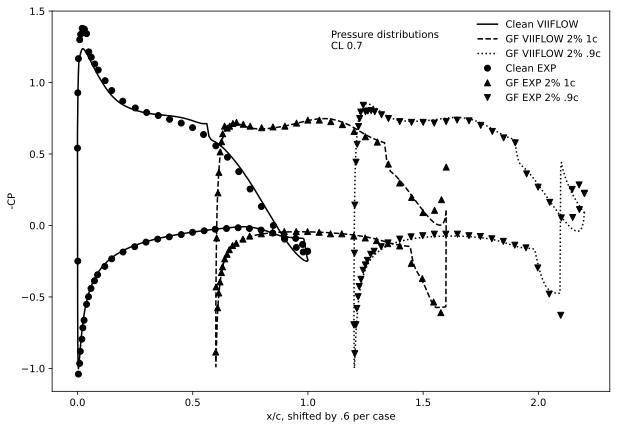

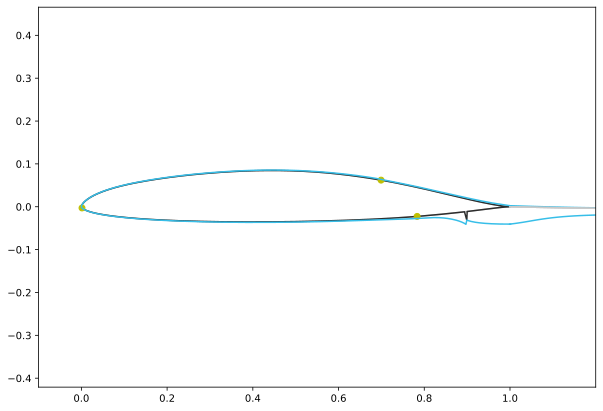

In [7]:
N = 320
AF = vft.repanel(vft.read_selig("S903RF.dat"),int(N),REFLIMS=[1.0,1.0,0.8,1.0],KAPFAC=.5,REFVAL=3,LEFAC=5,TEFAC = .5)

# Pressure comparison
hgv = [0.0,0.02,0.02]
pchord = [1,1,.9]
alphas = [4.5,0.15,1.5] # ->CL=0.7, read form above
lines = ['-','--',':']
shiftx = .6
shifty = 0

fig,ax = plt.subplots(1,1)
ax = [ax]
names = ['Clean VIIFLOW', 'GF VIIFLOW 2% 1c','GF VIIFLOW 2% .9c']
for k in range(len(hgv)):
    hg = hgv[k] 
    pc = pchord[k]
    alpha = alphas[k]
    
    vd = 0*AF[0,:]

    if pc>=1.0:
        index_gf = N-1
    else:
        for j in range(1,AF.shape[1]):
            if AF[0,-j]<pc:
                index_gf = N-j
                break
    vd[index_gf] = hg
    
    s.Alpha = alpha
    (p0,bl0,x0) = vf.init(AF,s)
    x0[p0.foils[0].N::p0.foils[0].N+p0.wakes[0].N-1]+=0.3
    if hg>0:
        xtrans = p0.foils[0].X[0,index_gf]-0.001
        vf.set_forced_transition(bl0,p0,[],[xtrans])
    [x,flag,res,grad,_] = vf.iter(x0,bl0,p0,s,None,None,[vd])

    ax[0].plot(p0.foils[0].X[0,:]+k*shiftx,-p0.cp[0:p0.foils[0].N]+k*shifty,label=names[k],color = colors[k],linestyle=lines[k])
    print(flag,p0.CL) # Print to check the CL ~.7

names = ['Clean EXP', 'GF EXP 2% 1c','GF EXP 2% .9c']
for k in range(3):
    Data = np.genfromtxt('S903GurneyCP.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0]+k*shiftx,Data.T[1]+k*shifty,'o',color = colors[k],label = names[k],marker=marks[k])
ax[0].legend(frameon=False)
ax[0].set_xlabel('x/c, shifted by .6 per case')
ax[0].set_ylabel('-CP')
ax[0].text(.5,.9,'Pressure distributions\nCL 0.7',
        horizontalalignment='left',
        transform=ax[0].transAxes);

fig,ax = plt.subplots(1,1)
ax = [ax]
vfp.plot_geometry(ax[0],p0,bl0);

[1] Liu, Tianshu, and Javier Montefort. *Thin-airfoil theoretical interpretation for Gurney flap lift enhancement.* Journal of Aircraft 44.2 (2007): 667-671.

[2] Jeffrey, David, Xin Zhang, and David W. Hurst. *Aerodynamics of Gurney flaps on a single-element high-lift wing.* Journal of Aircraft 37.2 (2000): 295-301.

[3] Troolin, D. R., E. K. Longmire, and W. T. Lai. *Time resolved PIV analysis of flow over a NACA 0015 airfoil with Gurney flap.* Experiments in Fluids 41.2 (2006): 241-254.

[4] Coder, James George. *CFD Investigation of Unsteady Rotorcraft Airfoil Aerodynamics.* (2010).

[5] Storms, Bruce L., and Cory S. Jang. *Lift enhancement of an airfoil using a Gurney flap and vortex generators.* Journal of Aircraft 31.3 (1994): 542-547.

[6] Jeffrey, David, Xin Zhang, and David W. Hurst. *Aerodynamics of Gurney flaps on a single-element high-lift wing.* Journal of Aircraft 37.2 (2000): 295-301.

[7] Maughmer, Mark D., and Götz Bramesfeld. *Experimental investigation of Gurney flaps.* Journal of Aircraft 45.6 (2008): 2062-2067.

[8] Somers, Dan M. *Effects of Airfoil Thickness and Maximum Lift Coefficient on Roughness Sensitivity: 1997--1998.* No. NREL/SR-500-36336. National Renewable Energy Lab., Golden, CO (US), 2005.